In [200]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn import neighbors
from sklearn import model_selection

In [2]:
'HDF ist ein deutlich besseres Format als csv/txt/... -> Dateitypen + Index bleibt erhalten '
pollution = pd.read_hdf("Pollution_Data/pollutant_data.h5")
predictor = pd.read_hdf("Predictor_Data/all.h5")
#predictor.info()
pollution.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3924 entries, 2010-01-01 to 2022-09-30
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   mean_co        3914 non-null   float64 
 1   max_value_co   3914 non-null   float64 
 2   max_hour_co    3914 non-null   float64 
 3   mean_so2       3566 non-null   float64 
 4   max_value_so2  3566 non-null   float64 
 5   max_hour_so2   3566 non-null   float64 
 6   mean_no2       3630 non-null   float64 
 7   max_value_no2  3630 non-null   float64 
 8   max_hour_no2   3630 non-null   float64 
 9   mean_o3        3777 non-null   float64 
 10  max_value_o3   3777 non-null   float64 
 11  max_hour_o3    3777 non-null   float64 
 12  mean_pm2_5     3414 non-null   float64 
 13  aqi_pm2_5      3414 non-null   category
 14  aqi_so2        3566 non-null   category
 15  aqi_no2        3630 non-null   category
 16  aqi_o3         3777 non-null   category
 17  aqi_idxmax     

In [3]:
pollution.columns

Index(['mean_co', 'max_value_co', 'max_hour_co', 'mean_so2', 'max_value_so2',
       'max_hour_so2', 'mean_no2', 'max_value_no2', 'max_hour_no2', 'mean_o3',
       'max_value_o3', 'max_hour_o3', 'mean_pm2_5', 'aqi_pm2_5', 'aqi_so2',
       'aqi_no2', 'aqi_o3', 'aqi_idxmax', 'aqi_max'],
      dtype='object')

In [100]:
#nur numerische Columns (ohne wind_direction da in Grad, ohne UV_radiation da sehr ähnlich zu radiation)
# auch ohne elektricity denn dadurch mehr Daten
numeric_columns=['mean_wind_speed', 'max_value_wind_speed', 'max_hour_wind_speed', 'mean_temp', 'max_value_temp',
       'max_hour_temp', 'mean_humidity', 'max_value_humidity',
       'max_hour_humidity', 'mean_radiation', 'max_value_radiation',
       'max_hour_radiation', 
        'mean_pressure', 'max_value_pressure',
       'max_hour_pressure', 'rain', 't_max', 't_min', 't_minmax',  'business_day']

quarter_dummi= pd.get_dummies(predictor["quarter"],prefix="quarter")
wind_dummi= pd.get_dummies(predictor["mean_wind_direction"],prefix="wind")
predict_today=predictor[numeric_columns]
predict_today = predict_today.join(quarter_dummi)
predict_today = predict_today.join(wind_dummi)

predict_today["business_day"]= predict_today["business_day"].astype(np.uint8)

# hinzufügen der Schadstoff Werte (ohne max_hour)
predict_today = predict_today.join(pollution.drop(['max_hour_co', 'max_hour_so2',
                                                   'max_hour_no2','max_hour_o3',"aqi_idxmax","aqi_max"],axis=1))

predict_today=predict_today.dropna()
predict_today.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1275 entries, 2015-04-01 to 2019-12-31
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   mean_wind_speed       1275 non-null   float64 
 1   max_value_wind_speed  1275 non-null   float64 
 2   max_hour_wind_speed   1275 non-null   float64 
 3   mean_temp             1275 non-null   float64 
 4   max_value_temp        1275 non-null   float64 
 5   max_hour_temp         1275 non-null   float64 
 6   mean_humidity         1275 non-null   float64 
 7   max_value_humidity    1275 non-null   float64 
 8   max_hour_humidity     1275 non-null   float64 
 9   mean_radiation        1275 non-null   float64 
 10  max_value_radiation   1275 non-null   float64 
 11  max_hour_radiation    1275 non-null   float64 
 12  mean_pressure         1275 non-null   float64 
 13  max_value_pressure    1275 non-null   float64 
 14  max_hour_pressure     1275 non-null   

In [101]:
predict_today["max_value_o3"].describe()

count    1275.000000
mean       96.219451
std        28.966362
min         7.700000
25%        77.000000
50%        94.300000
75%       113.500000
max       223.200000
Name: max_value_o3, dtype: float64

In [102]:
#vorher Standartisieren
col_to_scale=[     'mean_wind_speed', 'max_value_wind_speed',  'max_hour_wind_speed',
                  'mean_temp',       'max_value_temp',        'max_hour_temp',
              'mean_humidity',   'max_value_humidity',    'max_hour_humidity',
             'mean_radiation',  'max_value_radiation',   'max_hour_radiation',
              'mean_pressure',   'max_value_pressure',    'max_hour_pressure',
                       'rain',                't_max',                't_min',
                   't_minmax',              'mean_co',
               'max_value_co',             'mean_so2',        'max_value_so2',
                   'mean_no2',        'max_value_no2',              'mean_o3',
               'max_value_o3',           'mean_pm2_5']
st_scaler=StandardScaler()
predict_today[col_to_scale] = st_scaler.fit_transform(predict_today[col_to_scale])

predict_column="max_value_o3"
X_train , X_test , y_train , y_test = train_test_split(predict_today.drop(['aqi_pm2_5','aqi_so2',
                                                                           'aqi_no2','aqi_o3',predict_column,"mean_o3"],axis=1),
                                                       predict_today[predict_column])



Score of the model: 0.6423471275573518


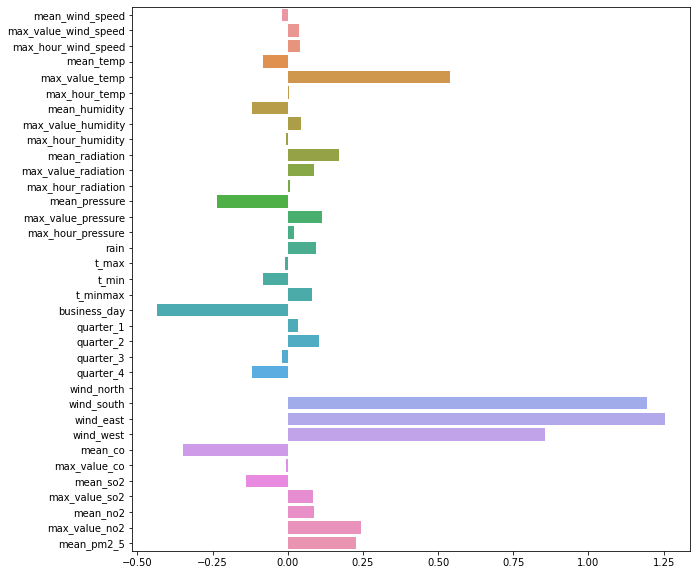

In [103]:
#einfachstes Modell -> linear
lin_reg=LinearRegression()
lin_reg.fit(X_train,y_train)
score= lin_reg.score(X_test,y_test)
print(f"Score of the model: {score}")
fig_coef, ax_coef = plt.subplots(1,1,figsize=(10,10))
ax_coef = sns.barplot(y=X_train.columns,x=lin_reg.coef_,orient="h")

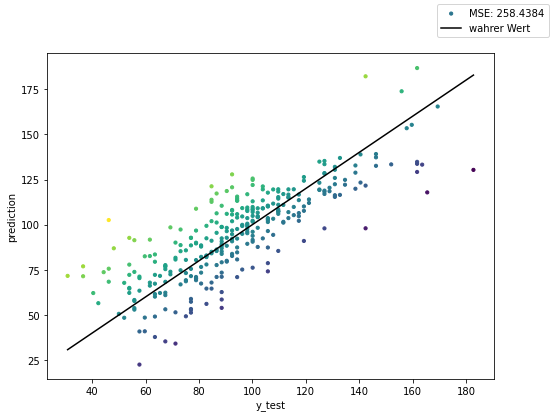

In [104]:
lin_reg_fig, lin_reg_ax= plt.subplots(1,1,figsize=(8,6))

st_scaler_attributes=pd.DataFrame(data={"mean":st_scaler.mean_,"var":np.sqrt(st_scaler.var_)},index=col_to_scale)
#Formula for reverse st_scaling x= z*s + u
y_true= y_test * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
y_predict = lin_reg.predict(X_test) * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
error = y_predict-y_true

mse=mean_squared_error(y_true=y_true,y_pred=y_predict)
lin_reg_ax.scatter(y_true,y_predict,s=10,c=error,cmap="viridis",label=f"MSE: {np.round(mse,4)}")
x=np.linspace(y_true.min(),y_true.max())
lin_reg_ax.plot(x,x,c="black",label="wahrer Wert")
lin_reg_ax.set_xlabel("y_test")
lin_reg_ax.set_ylabel("prediction")
lin_reg_fig.legend()


Score of the model: 0.6466333642095068


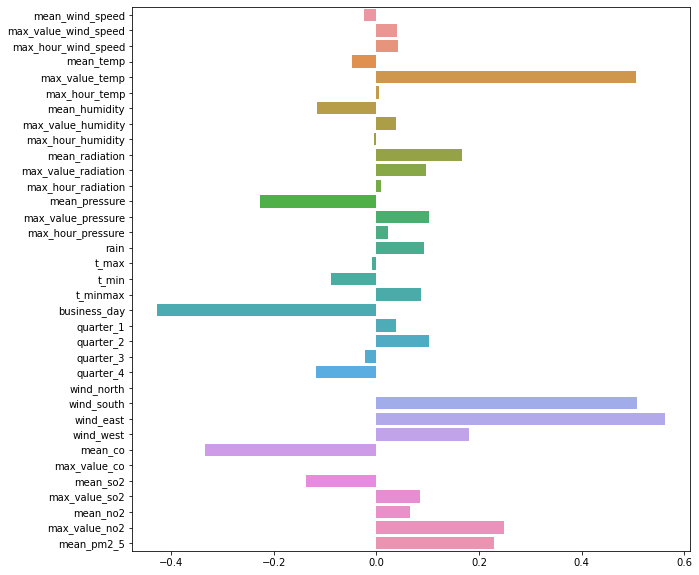

In [105]:
#einfachstes Modell -> linear Ridge
ridge_reg=Ridge()
ridge_reg.fit(X_train,y_train)
score= ridge_reg.score(X_test,y_test)
print(f"Score of the model: {score}")

fig_coef, ax_coef = plt.subplots(1,1,figsize=(10,10))
ax_coef = sns.barplot(y=X_train.columns,x=ridge_reg.coef_,orient="h")


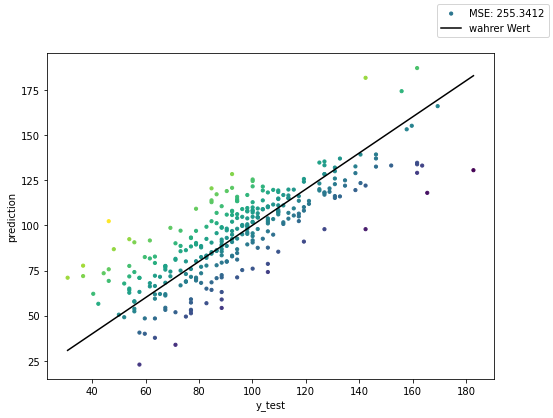

In [106]:
ridge_fig, ridge_ax= plt.subplots(1,1,figsize=(8,6))

st_scaler_attributes=pd.DataFrame(data={"mean":st_scaler.mean_,"var":np.sqrt(st_scaler.var_)},index=col_to_scale)
#Formula for reverse st_scaling x= z*s + u
y_true= y_test * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
y_predict = ridge_reg.predict(X_test) * st_scaler_attributes.loc["max_value_o3","var"] + st_scaler_attributes.loc["max_value_o3","mean"]
error = y_predict-y_true
mse=mean_squared_error(y_true=y_true,y_pred=y_predict)
ridge_ax.scatter(y_true,y_predict,s=10,c=error,cmap="viridis",label=f"MSE: {np.round(mse,4)}")
x=np.linspace(y_true.min(),y_true.max())
ridge_ax.plot(x,x,c="black",label="wahrer Wert")
ridge_ax.set_xlabel("y_test")
ridge_ax.set_ylabel("prediction")
ridge_fig.legend()

## supervised Clustering with aqi_o3

In [144]:
predict_column="aqi_o3"
X_train_classify , X_test_classify , y_train_classify , y_test_classify = train_test_split(predict_today.drop(['aqi_pm2_5','aqi_so2',
                                                                           'aqi_no2',predict_column,"mean_o3","max_value_o3"],axis=1),
                                                       predict_today[predict_column],random_state=1)
y_test_classify

2018-11-30        Fair
2018-08-10        Fair
2017-07-07        Poor
2018-04-05    Moderate
2016-06-04        Poor
                ...   
2017-11-26    Moderate
2017-10-13    Moderate
2018-11-22        Fair
2018-05-30        Fair
2017-10-02    Moderate
Name: aqi_o3, Length: 319, dtype: category
Categories (6, object): ['Good' < 'Fair' < 'Moderate' < 'Poor' < 'Very Poor' < 'Extremely Poor']

Score of the model: 0.7115987460815048
 balanced score of the model: 0.5000191905681249


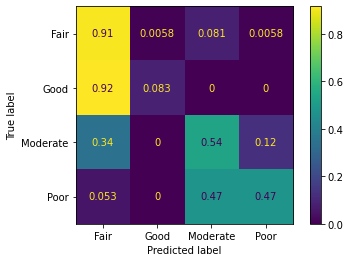

In [147]:
rfc = RandomForestClassifier(max_depth=200,min_samples_split=10)
rfc.fit(X_train_classify,y_train_classify)
score= rfc.score(X_test_classify,y_test_classify)
print(f"Score of the model: {score}")


In [ ]:
model=rfc
y_predict=model.predict(X_test_classify)
score_balanced= balanced_accuracy_score(y_true=y_test_classify,y_pred=y_predict)
print(f" balanced score of the model: {score_balanced}")

cm=confusion_matrix(y_true=y_test_classify,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

Für andere Classifikationen wird vorher eine PCA gemacht. 

In [267]:
knn_solo=neighbors.KNeighborsClassifier()
param={
    'n_neighbors': [2, 4, 6, 8],
    'weights': ['uniform', 'distance'],
    "metric" : ["cityblock","l2","cosine"]
    }
knn_search= model_selection.GridSearchCV(knn_solo,param,n_jobs=4,scoring=["f1_weighted","balanced_accuracy","accuracy"],refit="f1_weighted")
knn_search.fit(X_train_classify,y_train_classify)
knn_search_result=pd.DataFrame(knn_search.cv_results_)


 balanced score of the model: 0.5420436228531195
f1-Score: 0.6965959090903283


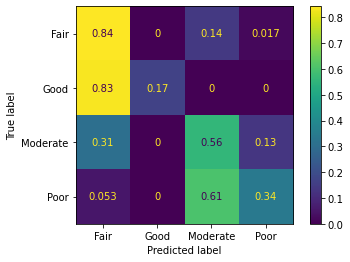

In [268]:
model=knn_search
y_predict=model.predict(X_test_classify)
score_balanced= knn_search_result.sort_values("rank_test_balanced_accuracy")["mean_test_balanced_accuracy"].iloc[0]
print(f" balanced score of the model: {score_balanced}")
f1=knn_search_result.sort_values("rank_test_f1_weighted")["mean_test_f1_weighted"].iloc[0]
print(f"f1-Score: {f1}")

cm=confusion_matrix(y_true=y_test_classify,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

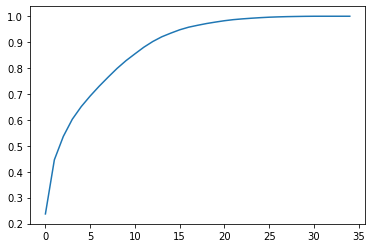

In [201]:
pca=decomposition.PCA()
'Important: only fit train data'
pca.fit(X_train_classify)

X_train_classify_pca=pca.transform(X_train_classify)
X_test_classify_pca=pca.transform(X_test_classify)

plt.plot(np.cumsum(pca.explained_variance_ratio_))


Gridsearch mit PCA und KNN -> dafür wird eine Pipeline erstellt
wie im [Beispiel](https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html) hier 
- Welche Metric ist die beste für Classifizierung ? [Medium Artikel](https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226)

In [224]:
pca_pipeline=decomposition.PCA()
knn_pipeline=neighbors.KNeighborsClassifier()

pipe=Pipeline(steps=[("pca",pca_pipeline),("knn",knn_pipeline)])
param={
    "pca__n_components": [1,4,8,11,12,13,14,15,16,17,23,30],
    'knn__n_neighbors': [2, 4, 6, 8],
    'knn__weights': ['uniform', 'distance'],
    "knn__metric" : ["cityblock","l2","cosine"]
    }
pca_knn_search= model_selection.GridSearchCV(pipe,param,n_jobs=4,scoring=["f1_weighted","balanced_accuracy","accuracy","recall"],refit="f1_weighted")
pca_knn_search.fit(X_train_classify,y_train_classify)


GridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=4,
             param_grid={'knn__metric': ['cityblock', 'l2', 'cosine'],
                         'knn__n_neighbors': [2, 4, 6, 8],
                         'knn__weights': ['uniform', 'distance'],
                         'pca__n_components': [1, 4, 8, 11, 12, 13, 14, 15, 16,
                                               17, 23, 30]},
             refit='f1_weighted',
             scoring=['f1_weighted', 'balanced_accuracy', 'accuracy'])

In [239]:
pca_knn_search_result=pd.DataFrame(pca_knn_search.cv_results_)
pca_knn_search_result.drop(['params', 'split0_test_f1_weighted',
       'split1_test_f1_weighted', 'split2_test_f1_weighted',
       'split3_test_f1_weighted', 'split4_test_f1_weighted','split0_test_balanced_accuracy',
       'split1_test_balanced_accuracy', 'split2_test_balanced_accuracy',
       'split3_test_balanced_accuracy', 'split4_test_balanced_accuracy','split0_test_accuracy',
       'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy',
       'split4_test_accuracy'],axis=1).sort_values("rank_test_balanced_accuracy").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__weights,param_pca__n_components,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
20,0.051245,0.015677,0.048822,0.013920,cityblock,2,distance,16,0.639229,0.018972,204,0.550026,0.034396,1,0.638084,0.017456,238
233,0.063658,0.026252,0.055668,0.016539,cosine,4,distance,13,0.676034,0.005524,74,0.546606,0.035465,2,0.680961,0.009389,133
19,0.054525,0.014120,0.055240,0.012569,cityblock,2,distance,15,0.641138,0.017889,198,0.546495,0.034006,3,0.641209,0.015483,234
116,0.058919,0.018607,0.049972,0.014919,l2,2,distance,16,0.639976,0.016278,200,0.545825,0.038647,4,0.640183,0.018214,235
18,0.047901,0.010759,0.052201,0.017144,cityblock,2,distance,14,0.639815,0.037206,202,0.541356,0.061522,5,0.640167,0.036781,236


In [255]:
pca_knn_search

GridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=4,
             param_grid={'knn__metric': ['cityblock', 'l2', 'cosine'],
                         'knn__n_neighbors': [2, 4, 6, 8],
                         'knn__weights': ['uniform', 'distance'],
                         'pca__n_components': [1, 4, 8, 11, 12, 13, 14, 15, 16,
                                               17, 23, 30]},
             refit='f1_weighted',
             scoring=['f1_weighted', 'balanced_accuracy', 'accuracy'])

 balanced score of the model: 0.5500256074970034
f1-Score: 0.6969355727656419


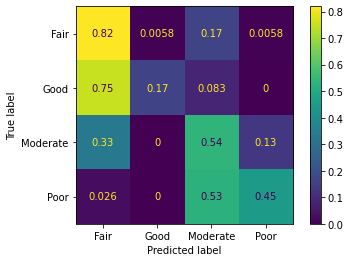

In [262]:
model=pca_knn_search
y_predict=model.predict(X_test_classify)
score_balanced= pca_knn_search_result.sort_values("rank_test_balanced_accuracy")["mean_test_balanced_accuracy"].iloc[0]
print(f" balanced score of the model: {score_balanced}")
f1=pca_knn_search_result.sort_values("rank_test_f1_weighted")["mean_test_f1_weighted"].iloc[0]
print(f"f1-Score: {f1}")

cm=confusion_matrix(y_true=y_test_classify,y_pred=y_predict,labels=model.classes_,normalize="true")
disp = ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()